<a href="https://colab.research.google.com/github/today-dawoon/aib-project/blob/main/section4_project_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section4 프로젝트: x-ray 이미지를 이용한 폐렴 분류 (CNN, Transfer Learning)


**1. 데이터 선정 이유**
- CNN, Transfer Learning을 통해 이미지를 학습하여 0-1의 이진 분류를 수행하기 위한 분석

- section2 프로젝트에서 자료형 의료 관련 데이터의 분류를 진행하였기에 이미지를 통한 분류를 경험해보고자 함

**2. EDA와 데이터 전처리**

- 훈련 데이터와 검증 데이터 재분류

- 베이스라인: target이 1(Pneumonia)인 값 74.2%

- 훈련 데이터셋의 이미지 형태를 조정하여 학습에 용이하게 처리

**3. 가설 및 평가지표**

- 가설1) exposure 라이브러리를 이용해 이미지의 노출을 조정해주면 성능이 더 높아질 것이다.

  -> 처리 과정에서 계속되는 에러로 인해 수행하지 못하였음.

- 가설1) CNN과 Transfer Learning의 성능은 비슷할 것이다.

- 평가지표: f1 score, precision, recall

**4. 가설 검증을 위한 모델 비교**

1) CNN

- 모델 구축

- 모델 훈련

- 모델 평가

2) Transfer Learning (VGG16)

- 모델 구축

- 모델 훈련

- 모델 평가


In [1]:
# 라이브러리 import
import os
from google.colab import drive

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.applications import VGG16

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## 2. EDA와 데이터 전처리

In [3]:
# 폴더 위치
train_folder = '/content/drive/MyDrive/chest_xray/train'
val_folder = '/content/drive/MyDrive/chest_xray/val'
test_folder = '/content/drive/MyDrive/chest_xray/test'

train_normal = train_folder + '/NORMAL/'
train_pneu= train_folder + '/PNEUMONIA/'

In [4]:
# 검증 데이터의 수가 너무 적음으로 훈련 데이터와 검증 데이터를 합쳐 정상/폐렴으로 분류하여 리스팅
filepath = []
categories = []

# 훈련 데이터
filenames = os.listdir(os.path.join(train_folder,'NORMAL'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'NORMAL',filename))
        categories.append("NORMAL")

filenames = os.listdir(os.path.join(train_folder,'PNEUMONIA'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'PNEUMONIA',filename))
        categories.append("PNEUMONIA")

# 검증 데이터
filenames = os.listdir(os.path.join(val_folder,'NORMAL'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'NORMAL',filename))
        categories.append("NORMAL")
        
filenames = os.listdir(os.path.join(val_folder,'PNEUMONIA'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'PNEUMONIA',filename))
        categories.append("PNEUMONIA")

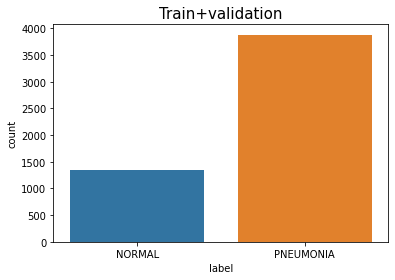

In [5]:
# 훈련+검증 데이터의 분포 확인
df = pd.DataFrame({'filepath':filepath,
                   'label':categories
                   }
                  )
sns.countplot(x ='label', data = df).set_title('Train+validation', size=15);

In [6]:
# 베이스라인 74.2%
print(df['label'].value_counts(normalize=True))

PNEUMONIA    0.742164
NORMAL       0.257836
Name: label, dtype: float64


(-0.5, 1183.5, 807.5, -0.5)

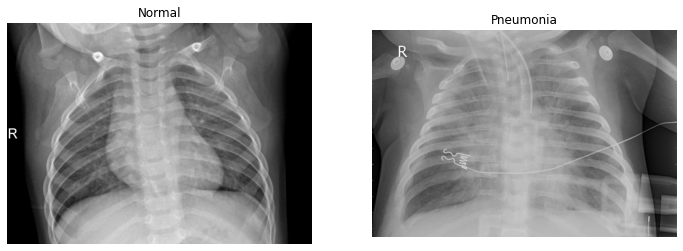

In [7]:
# 무작위 사진으로 normal과 pneumonia 비교
# normal
random_normal= np.random.randint(0,len(os.listdir(train_normal))) 
normal_img = os.listdir(train_normal)[random_normal]
normal_img_address = train_normal+normal_img

# pneumonia
random_pneumonia = np.random.randint(0,len(os.listdir(train_pneu)))
pneumonia_img =  os.listdir(train_pneu)[random_pneumonia]
pneumonia_img_address = train_pneu+pneumonia_img

normal_load = Image.open(normal_img_address)
pneumonia_load = Image.open(pneumonia_img_address)

figure = plt.figure(figsize= (12,12))
img1 = figure.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load, cmap = 'gray')
img1.set_title('Normal')
plt.axis("off")

img2 = figure.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load, cmap = 'gray')
img2.set_title('Pneumonia')
plt.axis("off")

In [8]:
# train, val 나누기 (test set의 크기를 고려하여 15%)
train, val = train_test_split(df, 
                              test_size=0.15, 
                              stratify=df['label'], 
                              random_state=6
                              )

In [9]:
# 변형 이미지를 만들어 학습셋에 포함시키기
train_datagen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range=0.3, 
                               shear_range=0.3,
                               zoom_range=0.3,
                               fill_mode='nearest'
                               )

train_generator = train_datagen.flow_from_dataframe(train,
                    x_col = 'filepath',
                    y_col = 'label',
                    target_size = (150, 150),
                    batch_size = 32,
                    class_mode = 'binary')

Found 4447 validated image filenames belonging to 2 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(val,
                      x_col = 'filepath',
                      y_col = 'label',
                      target_size=(150, 150),
                      batch_size=32,
                      class_mode='binary'
                      )

Found 785 validated image filenames belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_folder,
                      target_size = (150, 150),
                      batch_size = 32,
                      shuffle = False,
                      class_mode = 'binary'
                      )

Found 624 images belonging to 2 classes.


## 3. 가설 및 평가지표

- 가설1) exposure 라이브러리를 이용해 이미지의 노출을 조정해주면 성능이 더 높아질 것이다.

- 가설2) CNN과 Transfer Learning의 성능은 비슷할 것이다.

- 평가지표: f1 score, precision, recall

## 4. 가설 검증을 위한 모델 비교
### 1) CNN

- 모델 구축

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [14]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(save_best_only=True, 
                                                 filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1
                                                 )

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8,
                                                     restore_best_weights=True, 
                                                     verbose=1
                                                     )

- 모델 훈련

In [16]:
history = model.fit(train_generator,
            steps_per_epoch=100,
            epochs=20,
            validation_data=val_generator,
            validation_steps=4,
            callbacks=[cp_callback, early_stopping_cb]
            )

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7412
Epoch 00001: val_loss improved from inf to 0.37814, saving model to training_1/cp.ckpt
100/100 [==============================] - 266s 3s/step - loss: 0.5503 - accuracy: 0.7412 - val_loss: 0.3781 - val_accuracy: 0.7266
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.7702
Epoch 00002: val_loss improved from 0.37814 to 0.26900, saving model to training_1/cp.ckpt
100/100 [==============================] - 119s 1s/step - loss: 0.4090 - accuracy: 0.7702 - val_loss: 0.2690 - val_accuracy: 0.9219
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.8471
Epoch 00003: val_loss did not improve from 0.26900
100/100 [==============================] - 81s 810ms/step - loss: 0.3715 - accuracy: 0.8471 - val_loss: 0.3505 - val_accuracy: 0.8750
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.3554 - accura

In [17]:
# 모델 저장
model.save('CNN_PNEUMONIA.h5')

# cnn_model = load_model("./CNN_PNEUMONIA.h5")
# cnn_model

- 모델 평가

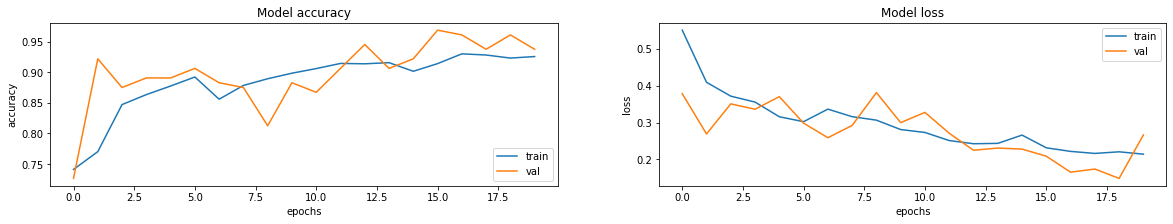

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [19]:
model.evaluate(test_generator)

20/20 [==============================] - 107s 6s/step - loss: 0.5840 - accuracy: 0.8526


[0.584026038646698, 0.8525640964508057]

In [20]:
predictions = model.predict(test_generator)
predictions = (predictions > 0.5).astype(np.int)

print(classification_report(test_generator.classes, 
                            predictions, 
                            target_names = ['Normal', 'Pneumonia']
                            )
)

              precision    recall  f1-score   support

      Normal       0.99      0.62      0.76       234
   Pneumonia       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.85      0.84       624



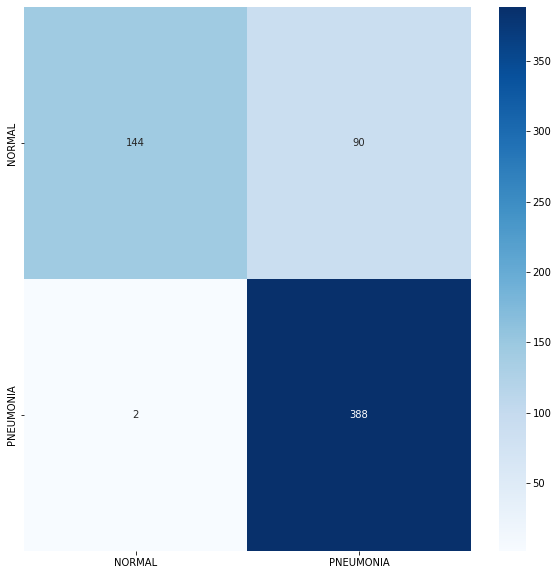

In [21]:
labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(test_generator.classes, predictions>0.5),
            cmap='Blues',
            annot = True, 
            fmt='',
            xticklabels = labels, 
            yticklabels = labels
            );

###  2) Transfer Learning (VGG)

- 모델 구축

In [22]:
tf.keras.backend.clear_session()

tf_model = VGG16(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

tf_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [23]:
tf_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [24]:
finetune_model = Sequential()
finetune_model.add(tf_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(1, activation='sigmoid'))
finetune_model.summary()

finetune_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


- 모델 학습

In [26]:
history = finetune_model.fit(train_generator,
                             steps_per_epoch=100,
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=4,
                             callbacks=[cp_callback, early_stopping_cb]
                             )

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9018
Epoch 00001: val_loss did not improve from 0.14866
100/100 [==============================] - 70s 699ms/step - loss: 0.2491 - accuracy: 0.9018 - val_loss: 0.1899 - val_accuracy: 0.9297
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9362
Epoch 00002: val_loss did not improve from 0.14866
100/100 [==============================] - 66s 662ms/step - loss: 0.1682 - accuracy: 0.9362 - val_loss: 0.2887 - val_accuracy: 0.8828
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9300
Epoch 00003: val_loss improved from 0.14866 to 0.14735, saving model to training_1/cp.ckpt
100/100 [==============================] - 67s 672ms/step - loss: 0.1705 - accuracy: 0.9300 - val_loss: 0.1473 - val_accuracy: 0.9453
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9475
Epoch 00004: val_loss

In [27]:
finetune_model.save('TRANSFER_PNEUMONIA.h5')

- 모델 평가

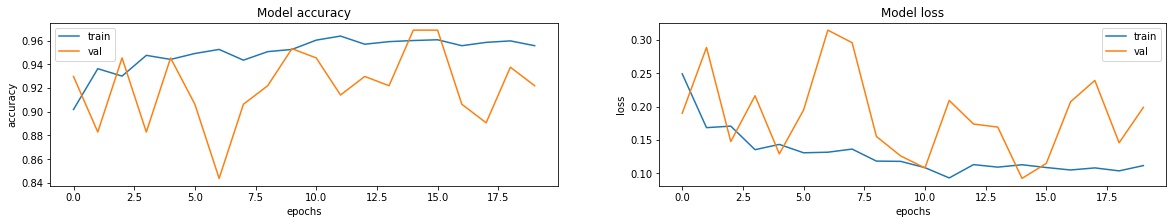

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
predictions = finetune_model.predict(test_generator)
predictions = (predictions > 0.5).astype(np.int)

print(classification_report(test_generator.classes, predictions, target_names = ['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.97      0.85      0.90       234
   Pneumonia       0.92      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



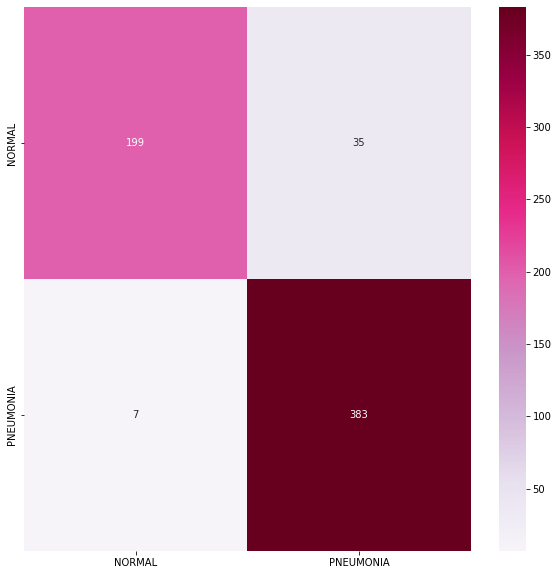

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(test_generator.classes, predictions>0.5), 
            cmap='PuRd',
            annot = True, 
            fmt='',
            xticklabels = labels, 
            yticklabels = labels
            );